# **Red Wine Quality Prediction** | Binary-class Classification

**Assignment 2 | EE4685 Machine Learning, a Bayesian Perspective**

*Authors: Yanqi Hong (5884683)
         Hongrui Liu (6005608)*

## 1. Importing Libraries and Data

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import random
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB,ComplementNB
from collections import Counter
from torch.distributions import constraints
from functools import partial

import torchbnn as bnn
from torchhk import transform_model

import gaussianize as g

#Neural Network libraries
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = "cuda"

# Set random seed
np.random.seed(888)
random_state = 888

In [2]:
# Load data
#Hong's path: data=pd.read_csv('E:\DATA\TUD\Master\TUD_Master_Y1\Q3\EE4685 Machine Learning, a Bayesian Perspective\Assignment 2\Data\winequality-red.csv')
data=pd.read_csv('E:\DATA\TUD\Master\TUD_Master_Y1\Q3\EE4685 Machine Learning, a Bayesian Perspective\Assignment 2\Data\winequality-red.csv')
display(data)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## 2. Data preprocessing

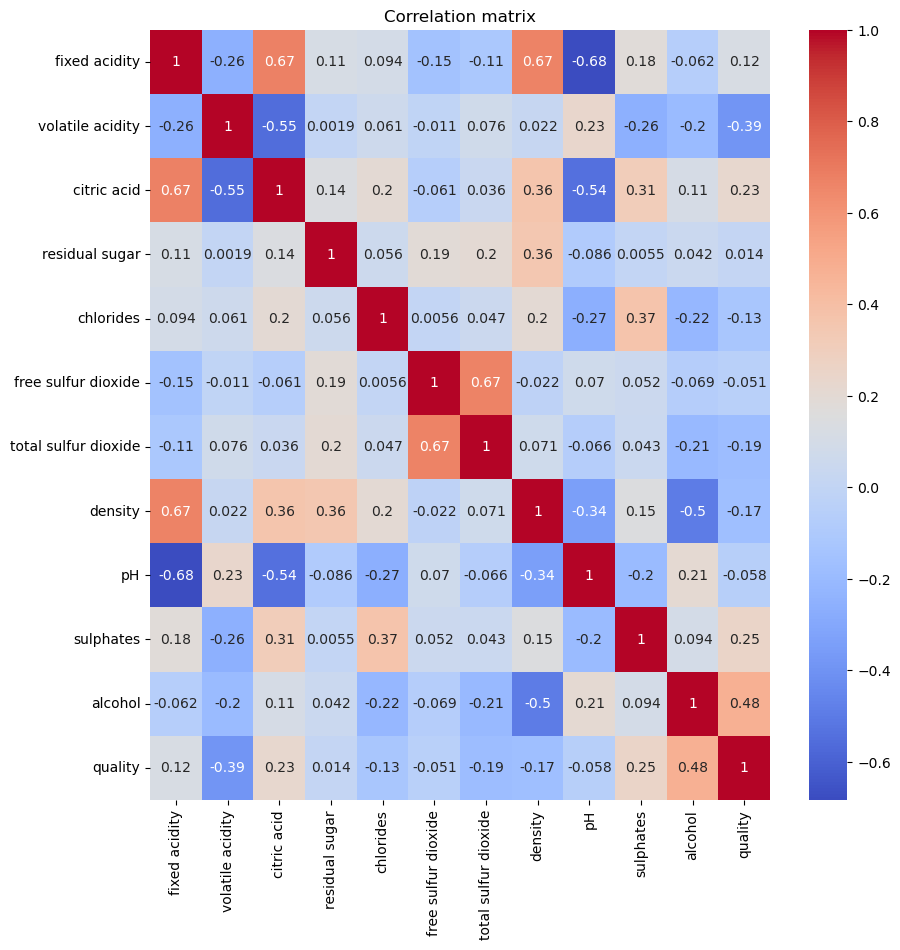

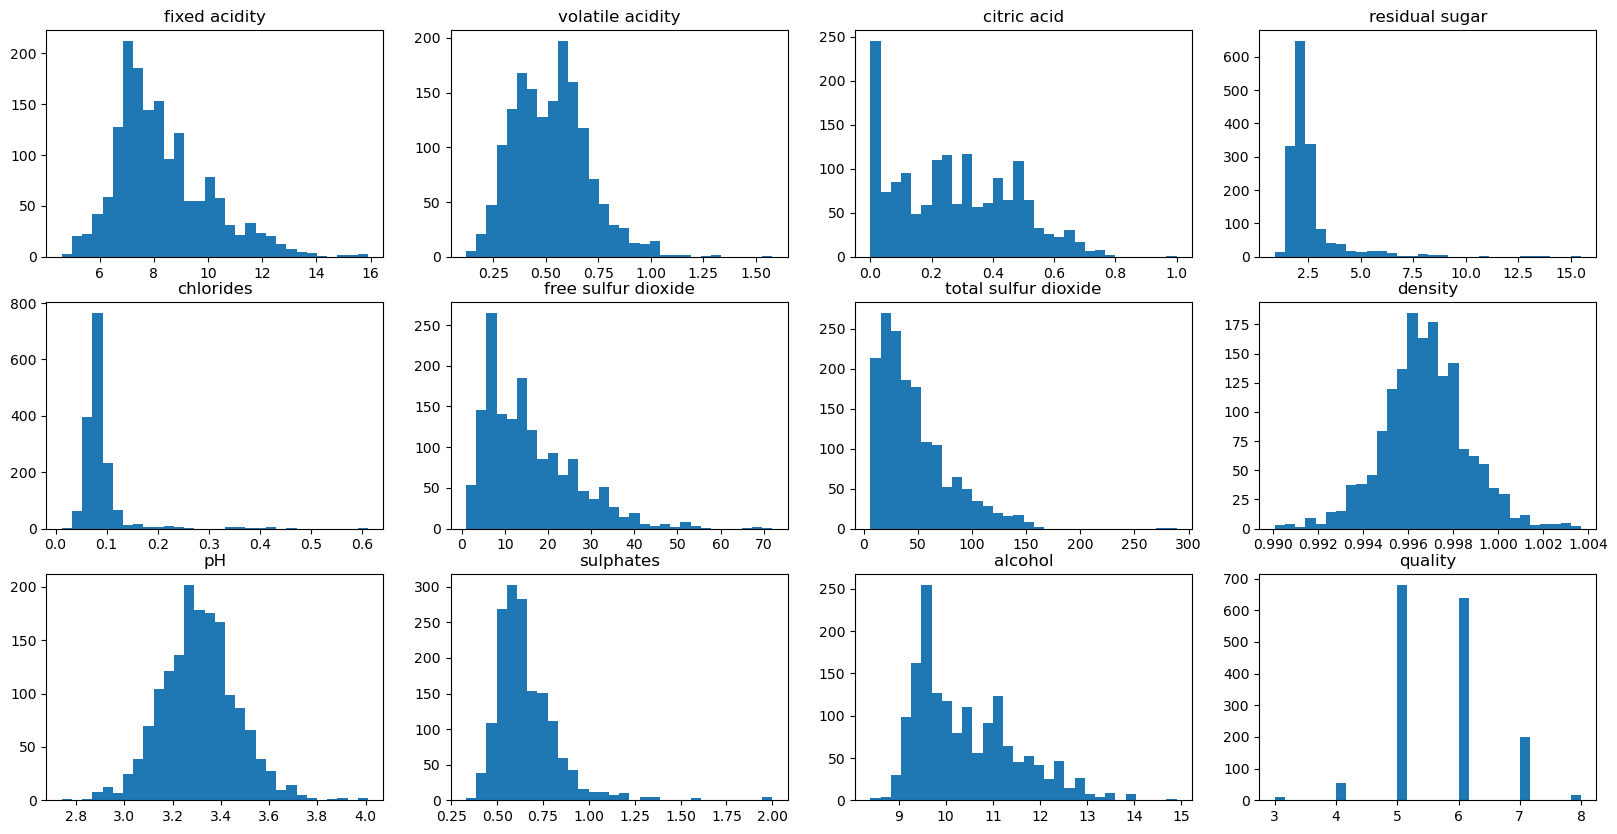

In [3]:
# Visualize data
# Correlation matrix, quality is the target variable
correlation_matrix = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

#Draw two histogram in one plot(one for good wine and one for bad wine), to see the distribution of each feature
plt.figure(figsize=(20, 10))
for i in range(0, 12):
    plt.subplot(3, 4, i+1)
    plt.hist(data.iloc[:, i], bins=30)
    plt.title(data.columns[i])
plt.show()

In [4]:
# calculate the number of samples in each quality class
quality_classes = data['quality'].value_counts()
print(quality_classes)

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


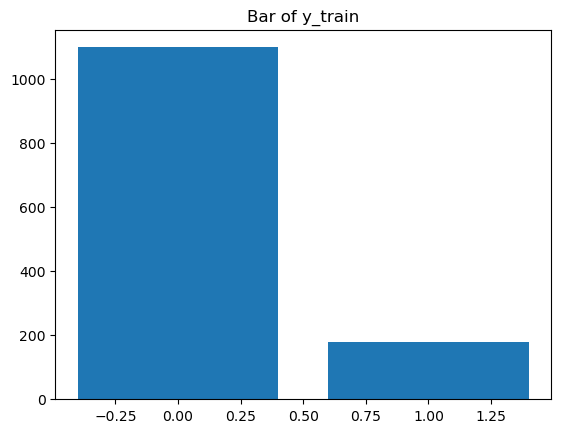

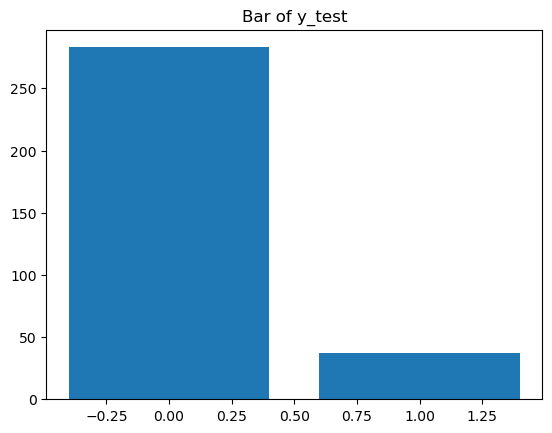

train 0    1099
1     180
dtype: int64
test 0    283
1     37
dtype: int64


In [5]:
x = data.iloc[:, :-1].values
# display(x)
y = data.iloc[:, -1].values

# change y to binary classification
y = np.where(y >= 7, 1, 0)  # 1: good, 0: bad

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=888)

#Histogram of the y_train
plt.bar([0, 1], [len(y_train[y_train == 0]), len(y_train[y_train == 1])])
plt.title('Bar of y_train')
plt.show()

#Histogram of the y_test
plt.bar([0, 1], [len(y_test[y_test == 0]), len(y_test[y_test == 1])])
plt.title('Bar of y_test')
plt.show()

# calculate the number of samples in each quality class
quality_classes_train = pd.Series(y_train).value_counts()
quality_classes_test = pd.Series(y_test).value_counts()
print("train",quality_classes_train)
print("test",quality_classes_test)





In [6]:

# Standardize features
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

The original number of training feature is:  11


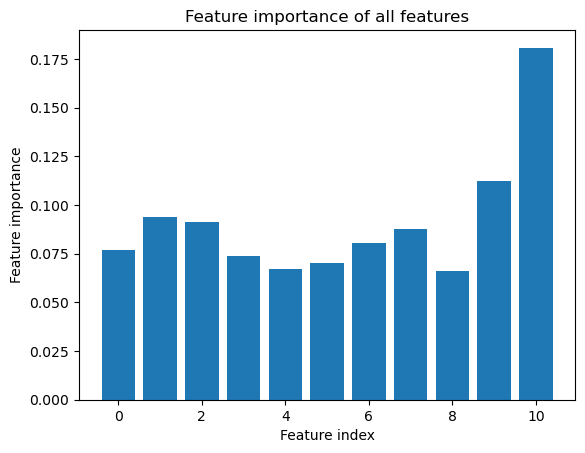

In [7]:

# Feature selection by extra tree classifier

print("The original number of training feature is: ", x_train.shape[1])
clf_etc = ExtraTreesClassifier(random_state=random_state).fit(x_train, y_train) # fit the model
feature_importances = clf_etc.feature_importances_  # get the feature importance

plt.bar(range(len(feature_importances)), feature_importances)   # plot the feature importance
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.title("Feature importance of all features")
plt.show()

# Feature is not too many, so we don't need to do feature selection
# However, if we want to do feature selection, we can use the following code
#---#
# important_feature_indices=np.argsort(feature_importances)   # sort the feature importance  
# important_feature_indices_cut=important_feature_indices[:int(len(important_feature_indices)/1.5)]   # select the most important features  
# X_train_selected=np.delete(x_train_scaled,important_feature_indices_cut,1)    # delete the least important features
# X_test_selected=np.delete(x_test_scaled,important_feature_indices_cut,1)      # delete the least important features
# print("The current number of training feature after feature selection is: ", X_train_selected.shape[1])
#---#


The number of features that explain 95% variance:  8


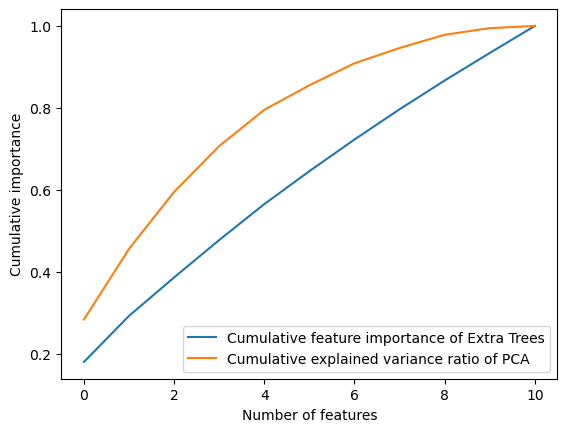

In [8]:
#ROC

# Plot the cumulative explained variance ratio for PCA and cumulative feature importance for Extra Trees
# Feature selection by PCA
pca0 = PCA().fit(x_train)
plt.plot(np.sort(feature_importances)[::-1].cumsum(), label='Cumulative feature importance of Extra Trees')
plt.plot(pca0.explained_variance_ratio_.cumsum(), label='Cumulative explained variance ratio of PCA')
plt.xlabel('Number of features')
plt.ylabel('Cumulative importance')
plt.legend()

print("The number of features that explain 95% variance: ", np.where(pca0.explained_variance_ratio_.cumsum() > 0.95)[0][0])

The number of negative values in x_train is:  8265


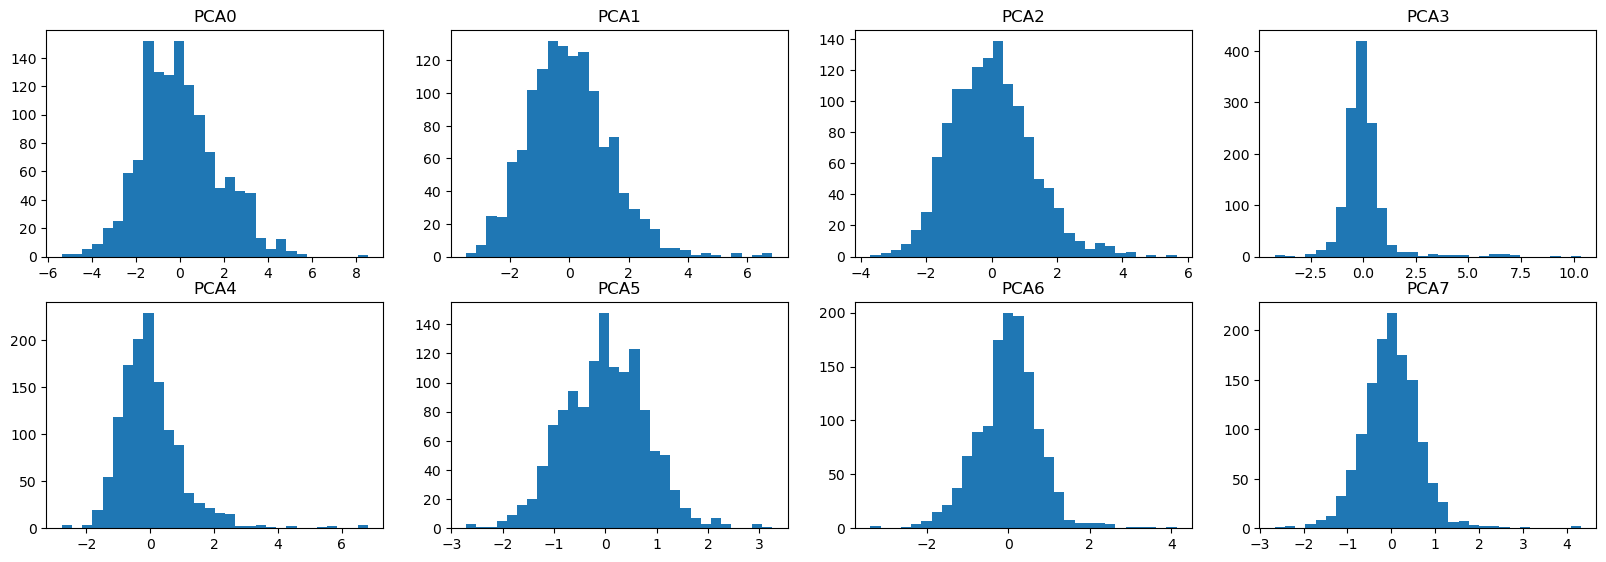

The number of negative values in x_train is:  5365


In [9]:
#check the negative values in the data
print("The number of negative values in x_train is: ", np.sum(x_train<0))

#PCA will generate negative values

# Feature selection by PCA, number of features that explain 95% variance, n_components=8
pca=PCA(n_components=8)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

#histgram of the x_train after PCA
plt.figure(figsize=(20, 10))
for i in range(0, 8):
    plt.subplot(3, 4, i+1)
    plt.hist(x_train[:, i], bins=30)
    plt.title("PCA"+str(i))
plt.show()


#check the negative values in the data
print("The number of negative values in x_train is: ", np.sum(x_train<0))

The original sample number of 0 is 1099
The original sample number of 1 is 180


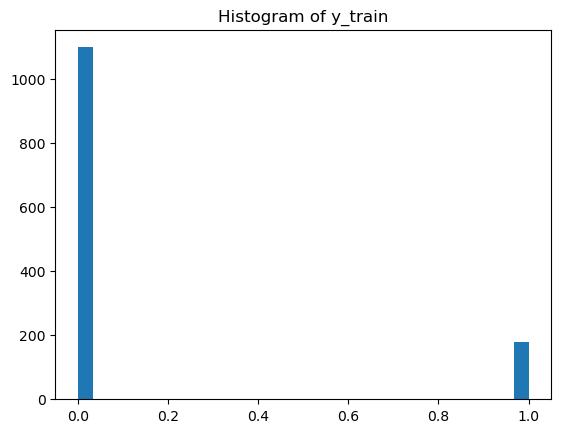

In [10]:
# oversample and undersample

# quality_list=[3,4,5,6,7,8]
quality_list=[0,1]
num_quanlity_list=[]
for i in quality_list:
    num_quanlity_list.append(np.sum(y_train==i))
    print('The original sample number of', i, 'is', num_quanlity_list[-1])

#Histogram of the y_train
plt.hist(y_train, bins=30)
plt.title('Histogram of y_train')
plt.show()

print("")

#SMOTE is not used, because of overfitting issue
# # # oversampling & undersampling
# smt = SMOTETomek(random_state=random_state)
# x_train, y_train = smt.fit_resample(x_train, y_train)
# num_quanlity_list=[]
# for i in quality_list:
#     num_quanlity_list.append(np.sum(y_train==i))
#     print('The processed sample number of', i, 'is', num_quanlity_list[-1])

# #Histogram of the y_train
# plt.hist(y_train, bins=30)
# plt.title('Histogram of y_train')
# plt.show()




## 3. Classification Models

In [37]:
def performance_eval(true, pred, score_display=True, matrix_display=False, result_return=False,multiple_pred=False):
    """
    Evaluate the performance of a binary classification model.

    Parameters:
    true (array-like): The true labels.
    pred (array-like): The predicted labels.
    score_display (bool, optional): Whether to display the performance scores. Default is True.
    matrix_display (bool, optional): Whether to display the confusion matrix. Default is False.
    result_return (bool, optional): Whether to return the performance scores. Default is False.
    multiple_pred (bool, optional): Whether there are multiple sets of predicted labels. Default is False.

    Returns:
    tuple: A tuple containing the performance scores (Accuracy, F1 score, Precision, Recall) if result_return is True.

    """
    if multiple_pred:
        Accuracy_list = []
        F1_list = []
        Precision_list = []
        Recall_list = []
        
        Accuracy = 0
        F1 = 0
        Precision = 0
        Recall = 0
        
        for i in range(len(pred)):
            Accuracy_list.append(accuracy_score(true, pred[i]))
            F1_list.append(f1_score(true, pred[i]))
            Precision_list.append(precision_score(true, pred[i]))
            Recall_list.append(recall_score(true, pred[i]))
        
        Accuracy = np.mean(Accuracy_list)
        F1 = np.mean(F1_list)
        Precision = np.mean(Precision_list)
        Recall = np.mean(Recall_list)
        
        if score_display==True:
            print("Accuracy: " + str(Accuracy))
            print("F1 score: " + str(F1))
            print("Recall score: " + str(Recall))
            print("Precision score: " + str(Precision))
            
        if matrix_display==True:
            # label = [3,4,5,6,7,8]
            label = ["bad","good"]
            cm_list = []
            for i in range(len(pred)):
                cm_list.append(confusion_matrix(true, pred[i])) 
            cm = np.mean(cm_list, axis=0)   # average the confusion matrix
            # cm is integer
            cm = cm.astype(int)
            cm_display = ConfusionMatrixDisplay(cm, display_labels=label).plot()
            plt.show(cm_display)
    else:
        Accuracy = accuracy_score(true, pred)
        F1 = f1_score(true, pred)
        Precision = precision_score(true, pred)
        Recall = recall_score(true, pred)
        
        if score_display==True:
            print("Accuracy: " + str(Accuracy))
            print("F1 score: " + str(F1))
            print("Recall score: " + str(Recall))
            print("Precision score: " + str(Precision))
            
        if matrix_display==True:
            # label = [3,4,5,6,7,8]
            label = ["bad","good"]
            cm = confusion_matrix(true, pred)
            cm_display = ConfusionMatrixDisplay(cm, display_labels=label).plot()
            plt.show(cm_display)
    
    if result_return:
        return Accuracy, F1, Precision, Recall

### 3.1 Naive Bayes

#### 3.1.1 Gaussian Naive Bayes

In [81]:

n_iter_search = 500
gnb=GaussianNB()

#calculate the prior
counter=Counter(y_train)
prior_0=counter[0]/len(y_train)
prior_1=counter[1]/len(y_train)

gnb_prior=[[prior_0,prior_1],[None]]
# gnb_prior=[[None]]


param_dist = { 'var_smoothing': np.logspace(0,-9, num=100), 'priors': gnb_prior}

random_search = RandomizedSearchCV(gnb, param_distributions=param_dist, 
                                   n_iter=n_iter_search, cv=5, 
                                   scoring='accuracy', random_state=random_state,
                                   n_jobs=8)

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 200 is smaller than n_iter=500. Running 200 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py", line 267, in fit
    return self._partial_fit(
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py", l

Accuracy: 0.9
F1 score: 0.42857142857142855
Recall score: 0.32432432432432434
Precision score: 0.631578947368421


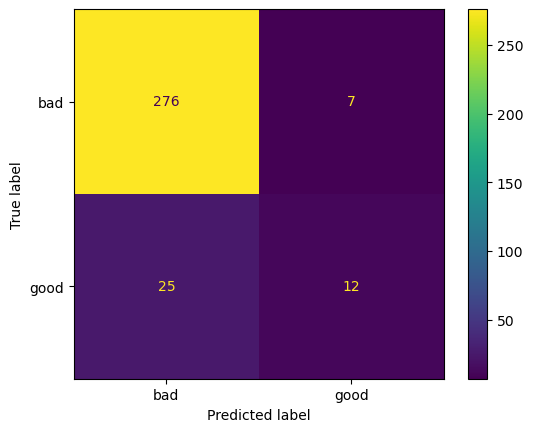

In [82]:
y_pred = random_search.predict(x_test)
Accuracy, F1, Precision, Recall=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)

In [83]:

#gnb summary
print("-----------------GNB Summary-----------------")
print("Best parameters:", best_params)
print("Best score in cross validation process:", best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("-------------------------------------------------------------")

-----------------GNB Summary-----------------
Best parameters: {'var_smoothing': 0.08111308307896872, 'priors': [0.8592650508209538, 0.14073494917904614]}
Best score in cross validation process: 0.874123774509804
Accuracy in test set with best parameters: 0.9
-------------------------------------------------------------


#### 3.1.2 Complement Naive Bayes

In [84]:
# CNB can not handle negative values, so we need to min-max scale the pca data

cnb_scaler = MinMaxScaler().fit(x_train)
x_train_cnb = cnb_scaler.transform(x_train)
x_test_cnb = cnb_scaler.transform(x_test)

n_iter_search = 5000
cnb = ComplementNB()

#calculate the prior
counter=Counter(y_train)
prior_0=counter[0]/len(y_train)
prior_1=counter[1]/len(y_train)
cnb_prior=[[prior_0,prior_1],[None]]

param_dist = { 'alpha': np.logspace(0,-9, num=100), 'fit_prior': [True, False], 'class_prior': cnb_prior, 'norm': [True, False]}
random_search = RandomizedSearchCV(cnb, param_distributions=param_dist,
                                      n_iter=n_iter_search, cv=5, 
                                      scoring='accuracy', random_state=random_state,
                                      n_jobs=8)

random_search.fit(x_train_cnb, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_



C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 800 is smaller than n_iter=5000. Running 800 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2000 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py", line 779, in fit
    self._update_class_log_prior(class_prior=class_prior)
  File "C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py", l

Accuracy: 0.76875
F1 score: 0.45588235294117646
Recall score: 0.8378378378378378
Precision score: 0.31313131313131315


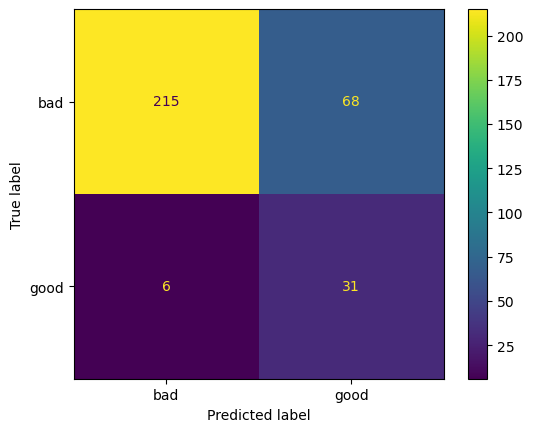

In [85]:

y_pred = random_search.predict(x_test_cnb)
Accuracy, F1, Precision, Recall=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)


In [86]:
#cnb summary
print("-----------------CNB Summary-----------------")
print("Best parameters:", best_params)
print("Best score in cross validation process:", best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("-------------------------------------------------------------")

-----------------CNB Summary-----------------
Best parameters: {'norm': False, 'fit_prior': True, 'class_prior': [0.8592650508209538, 0.14073494917904614], 'alpha': 0.2848035868435802}
Best score in cross validation process: 0.7826286764705882
Accuracy in test set with best parameters: 0.76875
-------------------------------------------------------------


### 3.2 Support Vector Classifier

In [87]:
# Random search for hyperparameter tuning

n_iter_search = 500
clf_svc_rs = SVC(max_iter=500)

# define the hyperparameter space
C = 1/np.power(10, np.arange(-4, 1, 1e-4))
param_dist = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid'], 
              "C": C, 
              'gamma': np.arange(0,1,1e-4)
              }

# random search
random_search = RandomizedSearchCV(clf_svc_rs, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=3, n_jobs=8,
                                   random_state=random_state)

random_search.fit(x_train, y_train)


best_params = random_search.best_params_
best_score = random_search.best_score_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.9125
F1 score: 0.5757575757575758
Recall score: 0.5135135135135135
Precision score: 0.6551724137931034


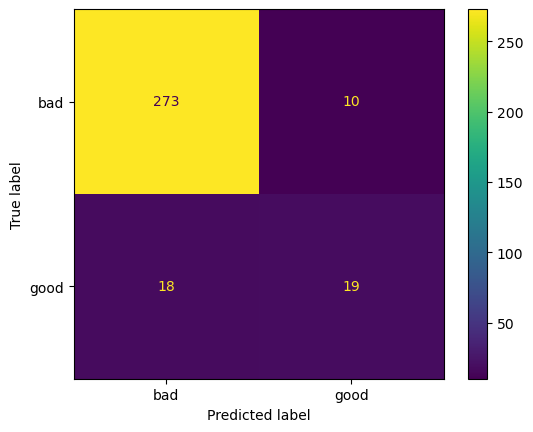

In [88]:
y_pred = random_search.predict(x_test)
Accuracy, F1, Precision, Recall=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)


In [89]:

#svc summary
print("-----------------SVC Summary-----------------")
print("Best parameters:", best_params)
print("Best score in cross validation process:", best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("-------------------------------------------------------------")

-----------------SVC Summary-----------------
Best parameters: {'kernel': 'rbf', 'gamma': 0.9672000000000001, 'C': 2.500921153736347}
Best score in cross validation process: 0.9007107843137255
Accuracy in test set with best parameters: 0.9125
-------------------------------------------------------------


### 3.3 Random Forest Classifier

In [90]:
# Random search for hyperparameter tuning
n_iter_search = 600

rf = RandomForestClassifier()

# define the hyperparameter space
max_depth = np.arange(5, 25).tolist()
max_depth.append(None)
param_dist = {"n_estimators": np.arange(10, 100),
              "max_depth": np.arange(5, 50),
              "min_samples_split": np.arange(25, 250),
              "min_samples_leaf": np.arange(25, 250)
              }

# random search
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=3, n_jobs=8)

random_search.fit(x_train, y_train)


best_params = random_search.best_params_
best_score = random_search.best_score_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


Accuracy: 0.8875
F1 score: 0.052631578947368425
Recall score: 0.02702702702702703
Precision score: 1.0


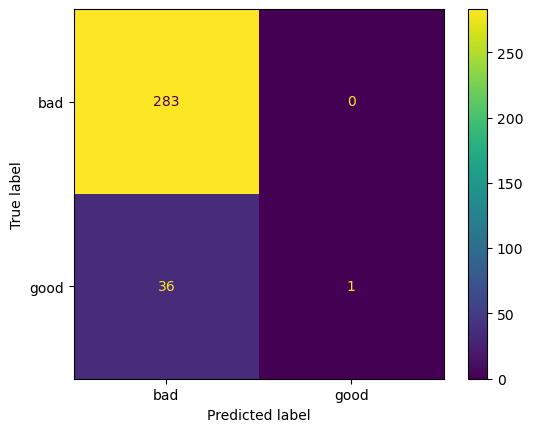

In [91]:
# Generate the performance value and confusion matrix on test set

y_pred = random_search.predict(x_test)
Accuracy, F1, Precision, Recall=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)

In [92]:
# random forest summary
print("-----------------Random Forest Summary-----------------")
print("Best parameters:", best_params)
print("Best score in cross validation process:", best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("-------------------------------------------------------------")

-----------------Random Forest Summary-----------------
Best parameters: {'n_estimators': 10, 'min_samples_split': 107, 'min_samples_leaf': 29, 'max_depth': 13}
Best score in cross validation process: 0.8670894607843138
Accuracy in test set with best parameters: 0.8875
-------------------------------------------------------------


### 3.3 Logistic Regression


In [93]:
# Random search for hyperparameter tuning

n_iter_search = 500 # number of iterations for random search
clf_lr_rs = LogisticRegression(max_iter=500, solver='saga') # define the model

# define the hyperparameter space
C = 1/np.power(10, np.arange(-4, 1, 1e-4))  
param_dist = {"penalty": ['l1', 'l2', 'elasticnet', None],
              "C": C,
              "l1_ratio": np.arange(0, 1, 1e-4)}

# random search
random_search = RandomizedSearchCV(clf_lr_rs, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=3, n_jobs=8,
                                   random_state=random_state)

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Accuracy: 0.884375
F1 score: 0.4307692307692308
Recall score: 0.3783783783783784
Precision score: 0.5


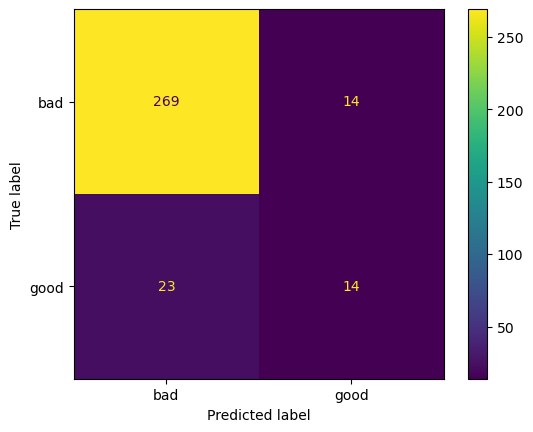

In [94]:
# Generate the performance value and confusion matrix on test set

y_pred = random_search.predict(x_test)
Accuracy, F1, Precision, Recall=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)

In [95]:
#linear regression summary

print("-----------------Logistic Regression Summary-----------------")
print("Best parameters:", best_params)
print("Best score in cross validation process:", best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("-------------------------------------------------------------")

-----------------Logistic Regression Summary-----------------
Best parameters: {'penalty': 'l2', 'l1_ratio': 0.8974000000000001, 'C': 0.2503225648327199}
Best score in cross validation process: 0.879592524509804
Accuracy in test set with best parameters: 0.884375
-------------------------------------------------------------


### 3.4 K-Nearest Neighbors

In [96]:
#knn
# Random search for hyperparameter tuning
n_iter_search = 500
clf_knn_rs = KNeighborsClassifier() # define the model

# define the hyperparameter space
n_neighbors = np.arange(1, 50)
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = np.arange(10, 100)
param_dist = {"n_neighbors": n_neighbors,
              "weights": weights,
              "algorithm": algorithm,
                "leaf_size": leaf_size}

# random search
random_search = RandomizedSearchCV(clf_knn_rs, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=3, n_jobs=8,
                                   random_state=random_state)

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Accuracy: 0.90625
F1 score: 0.5714285714285714
Recall score: 0.5405405405405406
Precision score: 0.6060606060606061


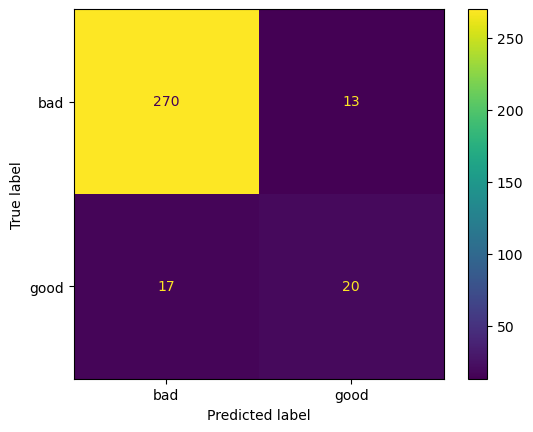

In [97]:

# Generate the performance value and confusion matrix on test set
y_pred = random_search.predict(x_test)
Accuracy, F1, Precision, Recall=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)


In [98]:

#knn summary
print("-----------------KNN Summary-----------------")
print("Best parameters:", best_params)
print("Best score in cross validation process:", best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("-------------------------------------------------------------")

-----------------KNN Summary-----------------
Best parameters: {'weights': 'distance', 'n_neighbors': 14, 'leaf_size': 77, 'algorithm': 'ball_tree'}
Best score in cross validation process: 0.9061764705882354
Accuracy in test set with best parameters: 0.90625
-------------------------------------------------------------


### 3.5 Nerual Network model

#### 3.5.1 Model Consruction Functions

In [11]:
# DNN class for random search
class NeuralNetwork(nn.Module):
    """
    Neural Network model for classification tasks.

    Args:
        input_size (int): The number of input features.
        hidden_sizes (list): A list of integers representing the number of units in each hidden layer.
        output_size (int): The number of output classes.
        activition_layer (nn.Module, optional): The activation function to be used in the hidden layers. 
            Available activation functions: ReLU, Sigmoid, Tanh, LeakyReLU, ELU, SELU, Softplus, Softsign, 
            LogSigmoid, PReLU, Softmin, Softmax. If not specified, ReLU will be used as the default activation function.

    Attributes:
        linear_relu_stack (nn.Sequential): The sequential stack of linear and activation layers.

    """

    def __init__(self, input_size, hidden_sizes, output_size, activition_layer=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        depth = len(hidden_sizes)
        layers = []
        for i in range(depth):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i])) 
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            if activition_layer == "ReLU":
                layers.append(nn.ReLU())
            elif activition_layer == "Sigmoid":
                layers.append(nn.Sigmoid())
            elif activition_layer == "Tanh":
                layers.append(nn.Tanh())
            elif activition_layer == "LeakyReLU":
                layers.append(nn.LeakyReLU())
            elif activition_layer == "ELU":
                layers.append(nn.ELU())
            elif activition_layer == "SELU":
                layers.append(nn.SELU())
            elif activition_layer == "Softplus":
                layers.append(nn.Softplus())
            elif activition_layer == "Softsign":
                layers.append(nn.Softsign())
            elif activition_layer == "LogSigmoid":
                layers.append(nn.LogSigmoid())
            elif activition_layer == "PReLU":
                layers.append(nn.PReLU())
            elif activition_layer == "Softmin":
                layers.append(nn.Softmin())
            elif activition_layer == "Softmax":
                layers.append(nn.Softmax())
            else:
                layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the neural network.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output logits.

        """
        logits = self.linear_relu_stack(x)
        return logits


In [12]:

class Data_tensor(Dataset):
    """
    A custom PyTorch dataset class for handling data and labels as tensors.
    
    Args:
        X (numpy.ndarray): The input data as a numpy array.
        y (numpy.ndarray): The labels as a numpy array.
        
    Attributes:
        X (torch.Tensor): The input data as a PyTorch tensor.
        y (torch.Tensor): The labels as a PyTorch tensor.
    """
    def __init__(self, X, y):
        X = np.float32(X)
        X = torch.from_numpy(X)
        # In pytorch, labels must start from 0
        # shift required
        y = np.longlong(y) - y.min()
        y = torch.from_numpy(y)
        
        self.X = X.to(device)
        self.y = y.to(device)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
# Train and test functions
def train(dataloader, model, loss_fn, optimizer):  
    """
    Trains the model on the given dataloader using the specified loss function and optimizer.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader containing the training data.
        model (torch.nn.Module): The model to be trained.
        loss_fn (torch.nn.Module): The loss function used to compute the prediction error.
        optimizer (torch.optim.Optimizer): The optimizer used for backpropagation.

    Returns:
        None
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>5f}  [{current:>5d}/{size:>5d}]")
           

In [14]:
 
def test(dataloader, model, loss_fn):
    """
    Evaluate the performance of a model on a test dataset.

    Args:
        dataloader (torch.utils.data.DataLoader): The test dataloader.
        model (torch.nn.Module): The model to be evaluated.
        loss_fn (torch.nn.Module): The loss function used for evaluation.

    Returns:
        None
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
# Test output for NeuralNetwork
input_size = x_train.shape[1]
output_size = 6
model_rs = NeuralNetwork(input_size, hidden_sizes=[100], output_size=output_size, activition_layer="PReLU")
print(model_rs)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss for multi-classification
optimizer_rs = torch.optim.Adam(model_rs.parameters(),weight_decay=0.005)   # Adam optimizer for random search

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=100, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=100, out_features=6, bias=True)
  )
)


#### 3.5.2 Model Cross Validation Functions

In [16]:
#k fold cross validation function
def Kfold_split(X_train, y_train, Shuffle_state, k=5):
    """
    Split the data into training and validation sets using K-fold cross validation.

    Parameters:
    - X_train (array-like): The input features of the training data.
    - y_train (array-like): The target values of the training data.
    - Shuffle_state (int): The random state for shuffling the data.
    - k (int, optional): The number of folds for cross validation. Default is 5.

    Returns:
    - X_k_train (list): List of training sets for each fold.
    - y_k_train (list): List of target values for each training set.
    - X_k_val (list): List of validation sets for each fold.
    - y_k_val (list): List of target values for each validation set.
    """
    kf = KFold(n_splits=k, random_state=Shuffle_state, shuffle=True)
    kf.get_n_splits(X_train)
    X_k_train = []
    y_k_train = []
    X_k_val = []
    y_k_val = []

    for train_index, val_index in kf.split(X_train):
        X_k_train.append(X_train[train_index])
        y_k_train.append(y_train[train_index])
        X_k_val.append(X_train[val_index])
        y_k_val.append(y_train[val_index])

    return X_k_train, y_k_train, X_k_val, y_k_val

In [17]:
# Create train and validation dataloader
batch_size = 1024

train_dataloader_list = []
val_dataloader_list = []

X_k_train_list, y_k_train_list, X_k_val_list, y_k_val_list = Kfold_split(x_train, y_train, random_state)   # K-fold cross validation for DNN
for i in range(5):
    trainset_gpu = Data_tensor(X_k_train_list[i], y_k_train_list[i])
    valset_gpu = Data_tensor(X_k_val_list[i], y_k_val_list[i])
    train_dataloader_list.append(DataLoader(trainset_gpu, batch_size=batch_size, shuffle=True))
    val_dataloader_list.append(DataLoader(valset_gpu, batch_size=batch_size, shuffle=True))
    
valset_gpu_k = Data_tensor(x_train, y_train)
val_dataloader_k = DataLoader(valset_gpu_k, batch_size=batch_size, shuffle=True)
testset_gpu = Data_tensor(x_test, y_test)
test_dataloader = DataLoader(testset_gpu, batch_size=batch_size, shuffle=False)

#### 3.5.3 Model Hyperparameter Space

In [28]:
# Define the hyper parameters for random search

min_width=8  # The minimum number of neurons in each hidden layer
max_width=512   # The maximum number of neurons in each hidden layer
min_hl=1    # The minimum number of hidden layers
max_hl=3   # The maximum number of hidden layers
activition_list = ["ReLU", "Tanh", "LeakyReLU","Sigmoid","Softmax"]   # The activation function list

optimizer_list = ["SGD", "Adam"]    
min_learning_rate=0.0001
max_learning_rate=1

#alpha: weight decay (L2 penalty)
max_alpha= 0         # denotes alpha=10^0
min_alpha= -5        # denotes alpha=10^-4

epochs = 20 # The maximum number of epochs for training

#BNN parameters: prior mean and std
prior_mu_min=-1
prior_mu_max=1
prior_sigma_min=0
prior_sigma_max=2

In [29]:


def get_hps(Bnn_model=False):
    """
    Generates a dictionary of hyperparameters for a neural network.

    Returns:
    dict: A dictionary containing the following hyperparameters:
        - hl (list): A list of hidden layer sizes.
        - alpha (float): The L2 regularization rate.
        - activition (str): The activation function.
        - optimizer (str): The optimizer algorithm.
        - lr (float): The learning rate.
    """
    if Bnn_model==False:
        num_hl = random.randint(min_hl, max_hl)
        hl = []
        for i in range(num_hl):
            hl.append(random.randint(min_width, max_width))
        alpha = np.power(10, random.uniform(min_alpha, max_alpha)) # The L2 rate is in the range of 10^-4 to 10^0
        activition = random.choice(activition_list)
        optimizer = random.choice(optimizer_list)
        lr = random.uniform(min_learning_rate, max_learning_rate)
        
        return {'hl': hl, 'alpha': alpha, 'activition': activition, 'optimizer': optimizer, 'lr': lr}
    else:
        num_hl = random.randint(min_hl, max_hl)
        hl = []
        for i in range(num_hl):
            hl.append(random.randint(min_width, max_width))
        alpha = np.power(10, random.uniform(min_alpha, max_alpha)) # The L2 rate is in the range of 10^-4 to 10^0
        activition = random.choice(activition_list)
        optimizer = random.choice(optimizer_list)
        lr = random.uniform(min_learning_rate, max_learning_rate)
        prior_mu = random.uniform(prior_mu_min, prior_mu_max)
        prior_sigma = random.uniform(prior_sigma_min, prior_sigma_max)
        
        return {'hl': hl, 'alpha': alpha, 'activition': activition, 'optimizer': optimizer, 'lr': lr, 'prior_mu': prior_mu, 'prior_sigma': prior_sigma}

#### 3.5.4 DNN Model Training and Evaluation

In [ ]:
# Random search on cross validation set

random.seed(random_state)

input_size=x_test.shape[-1]
output_size=2   # binary classification

num_search = 2000    # The number of random search

accuracy_list = []
hp_list = []
pm_list = []
DNN_time_list = []

for search in range(num_search):
    print('-'*20)
    print("Search progess: "+str(search+1)+"/"+str(num_search))
    print('-'*20)
    hp = get_hps()
    print(hp)
    model_rs = NeuralNetwork(input_size=input_size, hidden_sizes=hp['hl'], output_size=output_size, activition_layer=hp['activition']).to(device)
    
    if hp['optimizer'] == 'SGD':
        optimizer_rs = torch.optim.SGD(model_rs.parameters(), lr=hp['lr'], weight_decay=hp['alpha'])
    elif hp['optimizer'] == 'Adam':
        optimizer_rs = torch.optim.Adam(model_rs.parameters(), lr=hp['lr'], weight_decay=hp['alpha'])
    else:
        print("Error")
        break
        
    
    loss_fn = nn.CrossEntropyLoss()

    for i in range(epochs):
        train_dataloader = train_dataloader_list[i%5]
        validation_dataloader = val_dataloader_list[i%5]
        model_rs.train()
        start_time = time.time()
        train(train_dataloader, model_rs, loss_fn, optimizer_rs)
        train_time = time.time()-start_time
        DNN_time_list.append(train_time)
        
        test(validation_dataloader, model_rs, loss_fn)
        
        if (i+1)%5==0:
            model_rs.eval()
            pred = model_rs(val_dataloader_k.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
            true = val_dataloader_k.dataset[:][1].cpu().numpy()
            accuracy_list.append(accuracy_score(true, pred))
            hp.update({'epoch': i+1})
            hp_list.append(hp.copy())
            pm_list.append(model_rs.state_dict())
    print('-'*20)
    
accuracy_list = np.array(accuracy_list)



--------------------
The best accuracy in validation set is:  0.9288506645817045
The best hyperparameter is:  {'hl': [377], 'alpha': 0.0010123070560391005, 'activition': 'Tanh', 'optimizer': 'Adam', 'lr': 0.723393102484491, 'epoch': 20}
--------------------
-----------------DNN Summary-----------------
Model structure: 
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=377, bias=True)
    (1): Tanh()
    (2): Linear(in_features=377, out_features=2, bias=True)
  )
)
Accuracy: 0.871875
F1 score: 0.49382716049382713
Recall score: 0.5405405405405406
Precision score: 0.45454545454545453


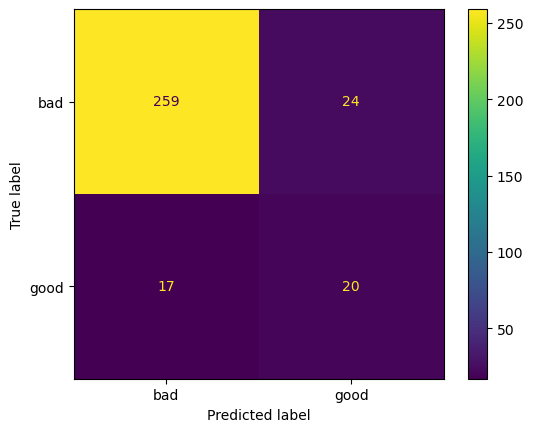

The average training time for each epoch is:  0.016227685856819152


In [109]:
# Find the best hyper parameters and show the performance on test set

best_idx = np.argmax(accuracy_list)
hp = hp_list[best_idx]
print("-"*20)
print("The best accuracy in validation set is: ", accuracy_list[best_idx])
print("The best hyperparameter is: ", hp)
print("-"*20)
model_best_dnn = NeuralNetwork(input_size=input_size, hidden_sizes=hp['hl'], output_size=output_size, activition_layer=hp['activition']).to(device)
model_best_dnn.load_state_dict(pm_list[best_idx])
print("-----------------DNN Summary-----------------")
print("Model structure: ")
print(model_best_dnn)
model_best_dnn.eval()
pred = model_best_dnn(test_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
true = test_dataloader.dataset[:][1].cpu().numpy()

performance_eval(true, pred, matrix_display=True)
print("The average training time for each epoch is: ", np.mean(DNN_time_list))

#### 3.5.5 BNN Model Training and Evaluation

In [ ]:
# Random search on cross validation set

random.seed(random_state)
input_size=x_test.shape[-1]
output_size=2   # binary classification

num_search = 2000   # The number of random search

accuracy_list = []
hp_list = []
pm_list = []
BNN_time_list = []

for search in range(num_search):
    print('-'*20)
    print("Search progess: "+str(search+1)+"/"+str(num_search))
    print('-'*20)
    hp = get_hps(Bnn_model=True)
    print(hp)
    model_rs = NeuralNetwork(input_size=input_size, hidden_sizes=hp['hl'], output_size=output_size, activition_layer=hp['activition']).to(device)

    # print(model_rs)

    mean_gauss = hp['prior_mu']

    var_gauss = hp['prior_sigma']
    

    #transofrm the model to bnn
    transform_model(model_rs, nn.Linear, bnn.BayesLinear, 
            args={"prior_mu":mean_gauss, "prior_sigma":var_gauss, "in_features" : ".in_features",
                  "out_features" : ".out_features", "bias":".bias"
                 }, 
            attrs={"weight_mu" : ".weight"})
    model_rs=model_rs.to(device)

    
    if hp['optimizer'] == 'SGD':
        optimizer_rs = torch.optim.SGD(model_rs.parameters(), lr=hp['lr'], weight_decay=hp['alpha'])
    elif hp['optimizer'] == 'Adam':
        optimizer_rs = torch.optim.Adam(model_rs.parameters(), lr=hp['lr'], weight_decay=hp['alpha'])
    else:
        print("Error")
        break
        
    loss_fn = nn.CrossEntropyLoss()

    for i in range(epochs):
        train_dataloader = train_dataloader_list[i%5]
        validation_dataloader = val_dataloader_list[i%5]
        model_rs.train()

        start_time = time.time()
        train(train_dataloader, model_rs, loss_fn, optimizer_rs)
        train_time = time.time() - start_time
        BNN_time_list.append(train_time)
        
        test(validation_dataloader, model_rs, loss_fn)
        
        if (i+1)%5==0:
            accuracy=0
            
            for j in range(30):  # Because BNN is a probabilistic model, we need to sample the model multiple times to get the prediction accuracy
                model_rs.eval()
                pred = model_rs(val_dataloader_k.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
                true = val_dataloader_k.dataset[:][1].cpu().numpy()
                accuracy+=accuracy_score(true, pred)
            accuracy_list.append(accuracy/30)
            hp.update({'epoch': i+1})
            hp_list.append(hp.copy())
            pm_list.append(model_rs.state_dict())
    print('-'*20)
    
accuracy_list = np.array(accuracy_list)


--------------------
The best accuracy in validation set is:  0.8838676048996615
The best hyperparameter is:  {'hl': [243, 246, 375], 'alpha': 7.41989634393618e-05, 'activition': 'Tanh', 'optimizer': 'SGD', 'lr': 0.6432918368423594, 'prior_mu': -0.06082290445805483, 'prior_sigma': 0.01509303235185322, 'epoch': 20}
--------------------
-----------------BNN Summary-----------------
Model structure: 
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): BayesLinear(prior_mu=-0.06082290445805483, prior_sigma=0.01509303235185322, in_features=8, out_features=243, bias=True)
    (1): Tanh()
    (2): BayesLinear(prior_mu=-0.06082290445805483, prior_sigma=0.01509303235185322, in_features=243, out_features=246, bias=True)
    (3): Tanh()
    (4): BayesLinear(prior_mu=-0.06082290445805483, prior_sigma=0.01509303235185322, in_features=246, out_features=375, bias=True)
    (5): Tanh()
    (6): BayesLinear(prior_mu=-0.06082290445805483, prior_sigma=0.01509303235185322, in_features=375, out_feat

C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torchhk\transform.py:34: Warning: 
 * Caution : The Input Model is CHANGED because inplace=True.
  warnings.warn("\n * Caution : The Input Model is CHANGED because inplace=True.", Warning)


Accuracy: 0.887290625
F1 score: 0.44390511770293456
Recall score: 0.39
Precision score: 0.5180326808982433


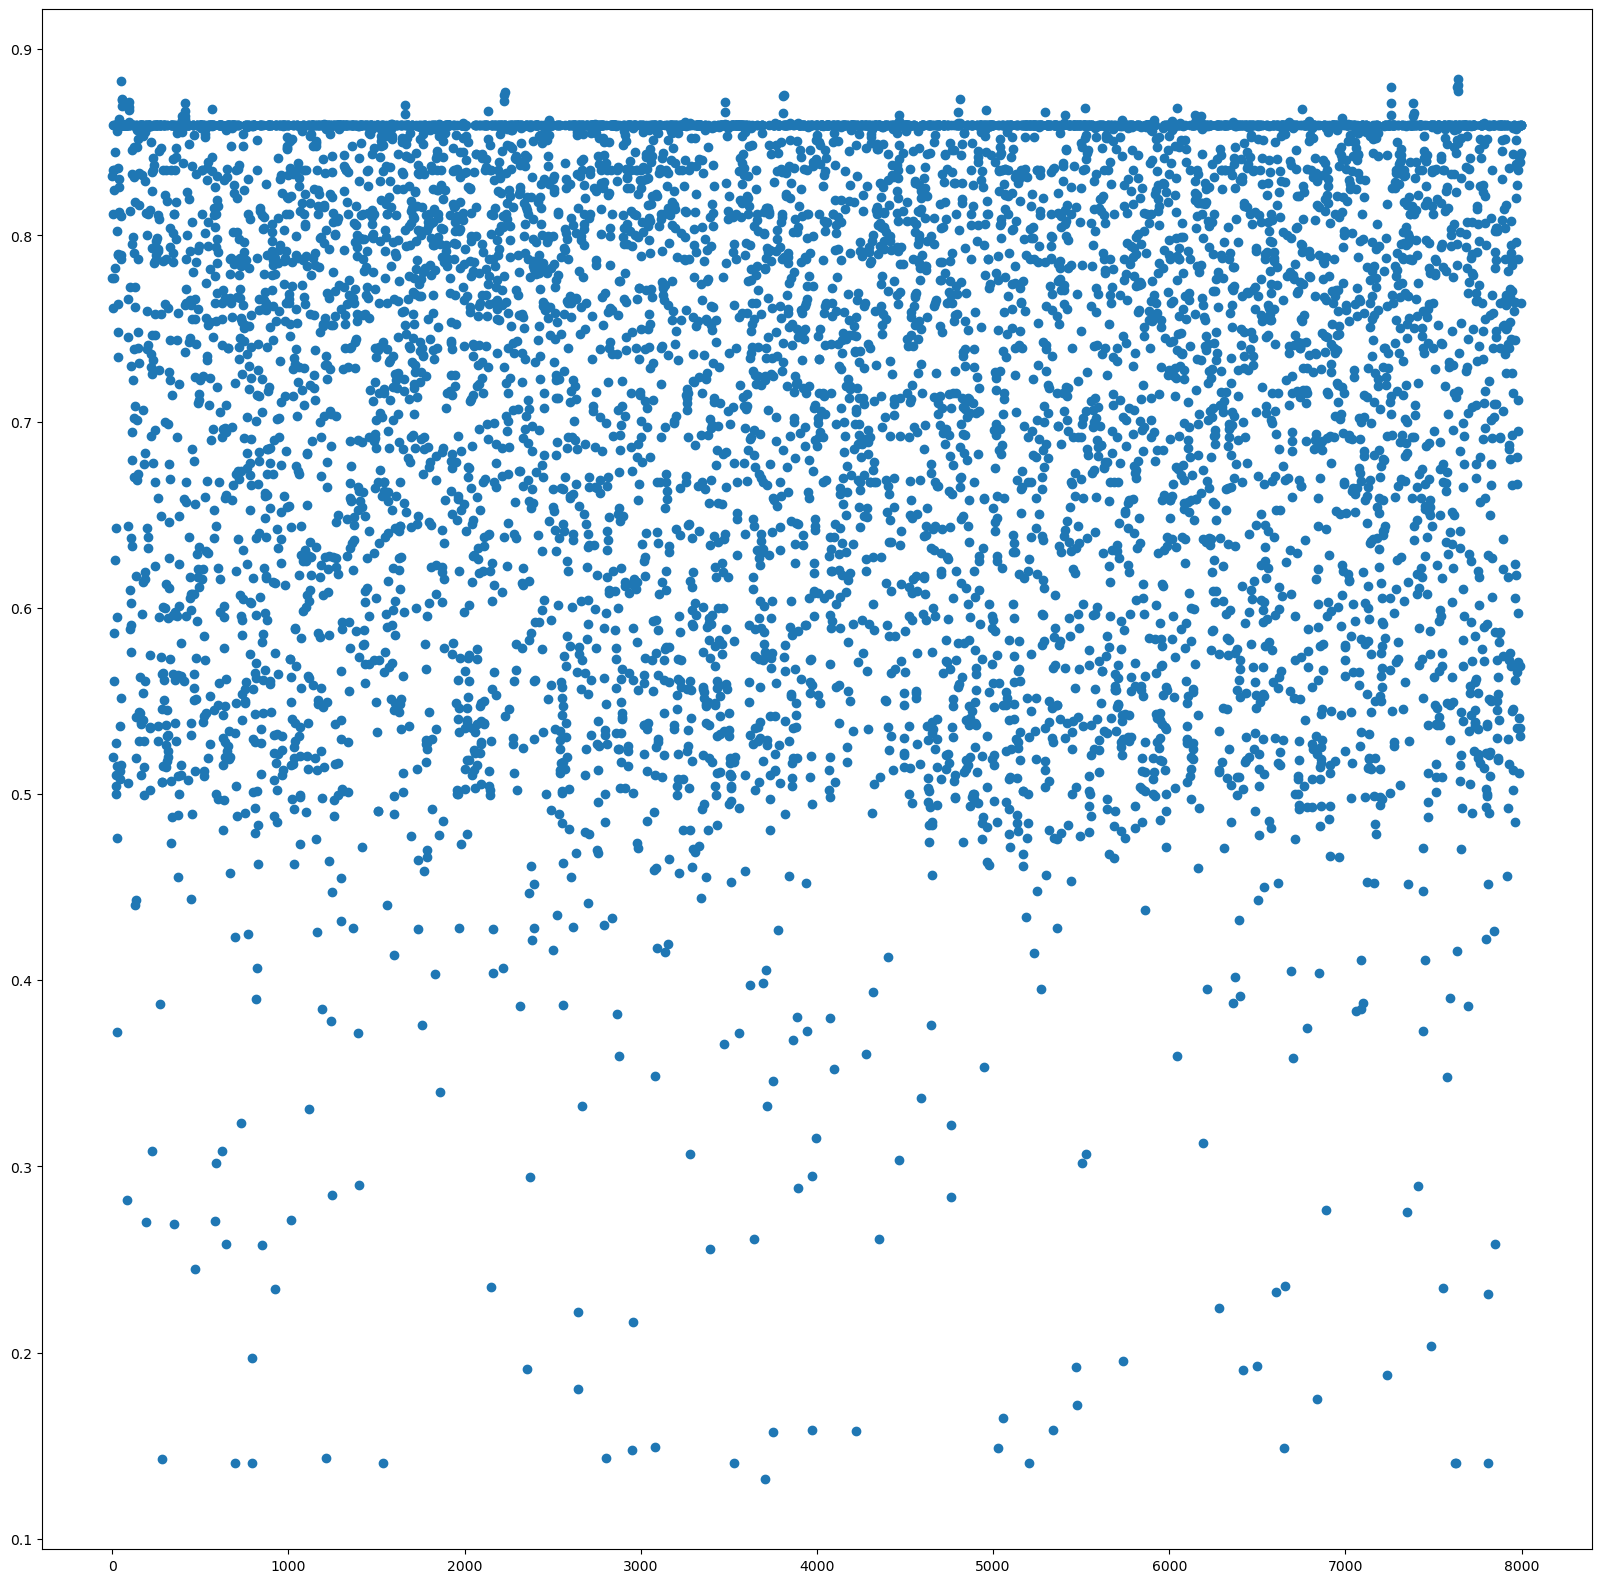

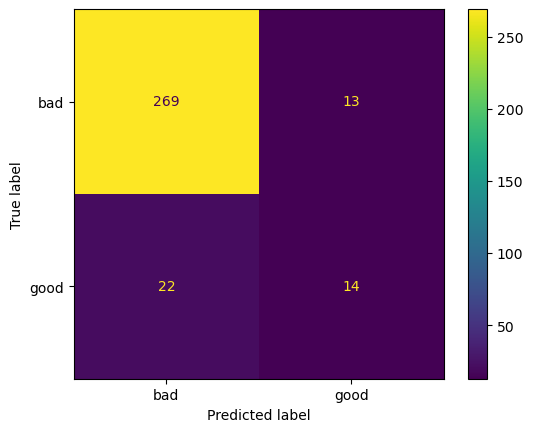

The average training time for each epoch is:  0.014670655190944671


In [44]:
# Find the best hyper parameters and show the performance on test set
plt.figure(figsize=(20,20))
plt.scatter(range(len(accuracy_list)), accuracy_list)
best_idx = np.argmax(accuracy_list)
hp = hp_list[best_idx]
print("-"*20)
print("The best accuracy in validation set is: ", accuracy_list[best_idx])
print("The best hyperparameter is: ", hp)
print("-"*20)
model_best = NeuralNetwork(input_size=input_size, hidden_sizes=hp['hl'], output_size=output_size, activition_layer=hp['activition']).to(device)
mean_gauss = hp['prior_mu']
var_gauss = hp['prior_sigma']
transform_model(model_best, nn.Linear, bnn.BayesLinear, 
            args={"prior_mu":mean_gauss, "prior_sigma":var_gauss, "in_features" : ".in_features",
                  "out_features" : ".out_features", "bias":".bias"
                 }, 
            attrs={"weight_mu" : ".weight"})
model_best.to(device)
print("-----------------BNN Summary-----------------")
print("Model structure: ")
print(model_best)
model_best.load_state_dict(pm_list[best_idx])
pred_list = []

#Because BNN is a probabilistic model, we need to sample the model multiple times to get the prediction accuracy
for j in range(1000):
    pred = model_best(test_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
    pred_list.append(pred)

true = test_dataloader.dataset[:][1].cpu().numpy()
print("Test set performance: ")
performance_eval(true, pred_list, matrix_display=True, multiple_pred=True)
print("The average training time for each epoch is: ", np.mean(BNN_time_list))